In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/GrupoMackenzie/ProjetoAplicado01-DataScience-Mackenzie-2025/refs/heads/main/datasets/nascidos_vivos_limpo.csv", encoding='latin1')

In [3]:
# Corrigindo para garantir 6 dígitos e adicionar "0" ao final para formar 7 na Tabulação conforme dicionário do datasus
df['CODMUNRES'] = df['CODMUNRES'].astype(str).str.zfill(6) + "0"

In [4]:
# Para transformar N em siglas
uf_siglas = {
    '11': 'RO', '12': 'AC', '13': 'AM', '14': 'RR', '15': 'PA', '16': 'AP', '17': 'TO',
    '21': 'MA', '22': 'PI', '23': 'CE', '24': 'RN', '25': 'PB', '26': 'PE', '27': 'AL', '28': 'SE', '29': 'BA',
    '31': 'MG', '32': 'ES', '33': 'RJ', '35': 'SP',
    '41': 'PR', '42': 'SC', '43': 'RS',
    '50': 'MS', '51': 'MT', '52': 'GO', '53': 'DF'
}

In [5]:
# Criar coluna UF com base no código do município
df['UF'] = df['CODMUNRES'].str[:2].map(uf_siglas)


📌 Total nacional de nascidos vivos: 2979259

📊 Nascidos vivos por estado (UF) com percentual sobre o total nacional:
AC    17139  (0.58%)
AL    51859  (1.74%)
AM    81145  (2.72%)
AP    16271  (0.55%)
BA   204034  (6.85%)
CE   128681  (4.32%)
DF    44721  (1.50%)
ES    56548  (1.90%)
GO    99798  (3.35%)
MA   117071  (3.93%)
MG   267130  (8.97%)
MS    44058  (1.48%)
MT    56499  (1.90%)
PA   143503  (4.82%)
PB    57535  (1.93%)
PE   143489  (4.82%)
PI    47941  (1.61%)
PR   159915  (5.37%)
RJ   233584  (7.84%)
RN    48111  (1.61%)
RO    27560  (0.93%)
RR    11120  (0.37%)
RS   143315  (4.81%)
SC    93232  (3.13%)
SE    34369  (1.15%)
SP   625687  (21.00%)
TO    24944  (0.84%)

🗺️ [BRASIL] Mapa de calor: total de nascidos vivos por estado:


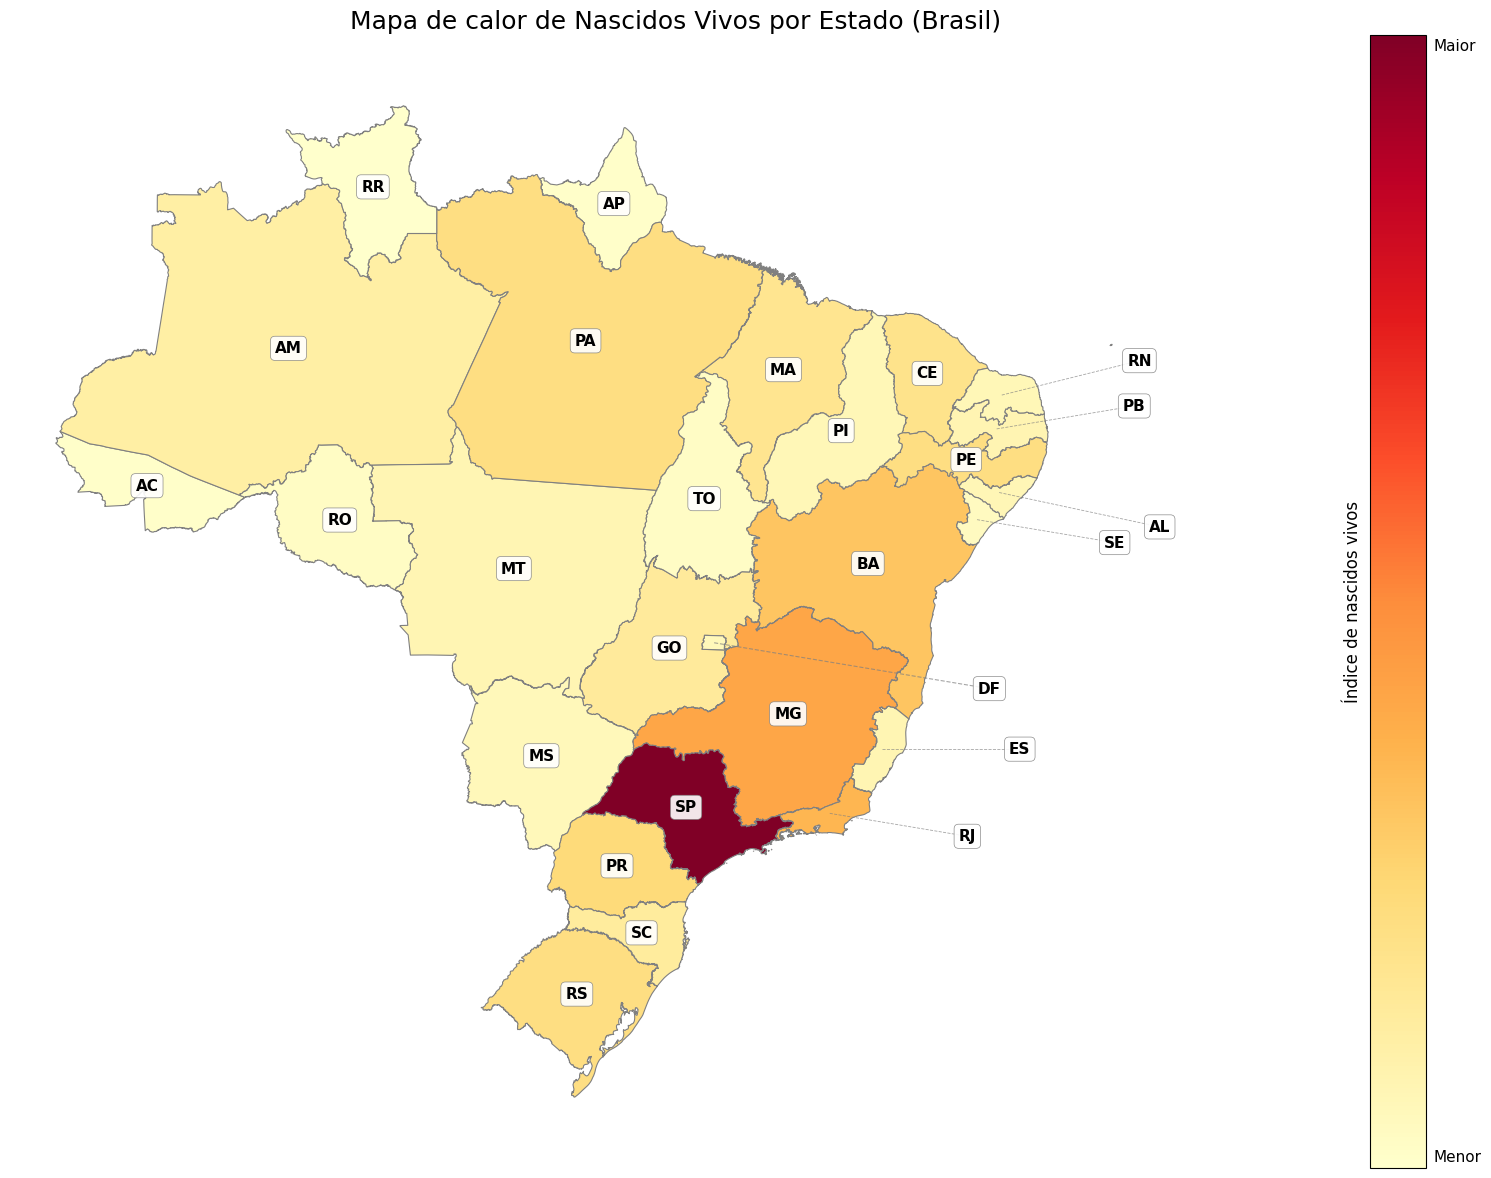

In [56]:
# -----------------------------
# BL.1 Total de nascidos vivos
# -----------------------------
total_nacional = len(df)
total_por_estado = df['UF'].value_counts().sort_index()

print("\n📌 Total nacional de nascidos vivos:", total_nacional)
print("\n📊 Nascidos vivos por estado (UF) com percentual sobre o total nacional:")
percentuais_estado = (total_por_estado / total_nacional * 100).round(2)
for uf in total_por_estado.index:
    total = total_por_estado[uf]
    perc = percentuais_estado[uf]
    print(f"{uf:<3} {total:>7}  ({perc:.2f}%)")


# 1.1. – Mapa dos nascidos vivos por UF (Brasil) – com siglas corrigidas manualmente

print("\n🗺️ [BRASIL] Mapa de calor: total de nascidos vivos por estado:")

# Configurações iniciais
geobr_path = 'https://raw.githubusercontent.com/GrupoMackenzie/ProjetoAplicado01-DataScience-Mackenzie-2025/main/src/br_estados.geojson'
gdf = gpd.read_file(geobr_path).to_crs(epsg=5880)
nascimentos_por_uf = df['UF'].value_counts().rename_axis('UF').reset_index(name='NASCIDOS')
gdf['UF'] = gdf['sigla'] if 'sigla' in gdf.columns else gdf['UF']
gdf = gdf.merge(nascimentos_por_uf, on='UF', how='left')

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='NASCIDOS', cmap='YlOrRd', linewidth=0.8, edgecolor='gray', ax=ax)
plt.title('Mapa de calor de Nascidos Vivos por Estado (Brasil)', fontsize=18, pad=20)
plt.axis('off')

# Configurações das siglas (conforme ajustes anteriores)
siglas_config = {
    'DF': {'offset': (1200000, -200000), 'linewidth': 0.8},
    'SE': {'offset': (600000, -100000), 'linewidth': 0.6},
    'AL': {'offset': (700000, -150000), 'linewidth': 0.6},
    'ES': {'offset': (600000, 0), 'linewidth': 0.6},
    'RJ': {'offset': (600000, -100000), 'linewidth': 0.6},
    'PB': {'offset': (600000, 100000), 'linewidth': 0.6},
    'RN': {'offset': (600000, 150000), 'linewidth': 0.6}
}

for idx, row in gdf.iterrows():
    uf = row['UF']
    centroid = row['geometry'].centroid.coords[0]

    if uf in siglas_config:
        cfg = siglas_config[uf]
        text_pos = (centroid[0] + cfg['offset'][0], centroid[1] + cfg['offset'][1])

        ax.plot([centroid[0], text_pos[0]], [centroid[1], text_pos[1]],
                color='gray', linestyle='--', linewidth=cfg['linewidth'], alpha=0.7)

        ax.text(text_pos[0], text_pos[1], uf,
                ha='center', va='center',
                fontsize=11, color='black', weight='bold',
                bbox=dict(
                    facecolor='white',
                    alpha=0.9,
                    edgecolor='gray',
                    boxstyle='round,pad=0.3',
                    linewidth=0.5
                ))
    else:
        ax.text(centroid[0], centroid[1], uf,
                ha='center', va='center',
                fontsize=11, color='black', weight='bold',
                bbox=dict(
                    facecolor='white',
                    alpha=0.9,
                    edgecolor='gray',
                    boxstyle='round,pad=0.3',
                    linewidth=0.5
                ))

# BARRA DE LEGENDA
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=gdf['NASCIDOS'].min(), vmax=gdf['NASCIDOS'].max()))
cbar = fig.colorbar(sm, orientation="vertical", fraction=0.04, pad=0.02, ax=ax)
cbar.set_ticks([])

# Elementos da legenda
cbar.ax.plot([1.05, 1.10], [0.01, 0.01], color='black', transform=cbar.ax.transAxes)
cbar.ax.text(1.12, 0.01, 'Menor', va='center', fontsize=11, weight='normal',
             transform=cbar.ax.transAxes)  # Aumentado e negrito
cbar.ax.plot([1.05, 1.10], [0.99, 0.99], color='black', transform=cbar.ax.transAxes)
cbar.ax.text(1.12, 0.99, 'Maior', va='center', fontsize=11, weight='normal',
             transform=cbar.ax.transAxes)  # Aumentado e negrito
cbar.ax.text(-0.3, 0.5, 'Índice de nascidos vivos', va='center', ha='center',  # -0.3 para aproximar
             rotation=90, fontsize=12, weight='normal', transform=cbar.ax.transAxes)  # Aumentado e negrito

# Ajuste do layout
ax.set_xlim(gdf.total_bounds[0] - 200000, gdf.total_bounds[2] + 1000000)
plt.tight_layout()
plt.show()

In [6]:
# -----------------------------
# BL.2 Classificação de pré-natal
# -----------------------------
def classificar_consultas(valor):
    try:
        v = float(valor)
    except:
        v = 0
    if v == 0:
        return 'Nenhum'
    elif 1 <= v <= 5:
        return 'Inadequado'
    elif 6 <= v <= 7:
        return 'Mínimo'
    elif 8 <= v <= 14:
        return 'Adequado'
    elif v > 14:
        return 'Incomum'
    else:
        return 'Nenhum'

df['CATEGORIA_PRENATAL'] = df['CONSPRENAT'].apply(classificar_consultas)

In [ ]:
# Nacional
print("\n📊 Classificação nacional de pré-natal:")
print(df['CATEGORIA_PRENATAL'].value_counts())

In [ ]:
# Por estado
print("\n📊 Classificação de pré-natal por estado (UF):")
print(df.groupby(['UF', 'CATEGORIA_PRENATAL']).size().unstack().fillna(0).astype(int))

In [ ]:
# 2.1 Gráfico de Classificação de pré-natal por região

print("\n📊 [BRASIL] Distribuição da qualidade do pré-natal por região:")

In [7]:
# Mapeando estados por região
regioes = {
    'Norte':     ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste':  ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste':   ['ES', 'MG', 'RJ', 'SP'],
    'Sul':       ['PR', 'RS', 'SC']
}

In [8]:
# Cria coluna 'REGIAO'
def mapear_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return 'Ignorado'

df['REGIAO'] = df['UF'].apply(mapear_regiao)

In [9]:
# Para agrupa categorias
def classificar_grupo(cat):
    if cat in ['Nenhum', 'Inadequado']:
        return 'Ruim'
    elif cat == 'Mínimo':
        return 'Bom'
    elif cat in ['Adequado', 'Incomum']:
        return 'Ótimo'
    else:
        return 'Ignorado'

df['GRUPO_PRENATAL'] = df['CATEGORIA_PRENATAL'].apply(classificar_grupo)

In [10]:
# Criar tabela de distribuição percentual por região
tabela = df[df['GRUPO_PRENATAL'] != 'Ignorado'].groupby(['REGIAO', 'GRUPO_PRENATAL']).size().unstack().fillna(0)

In [11]:
# Normalizar para obter percentual
tabela_pct = (tabela.T / tabela.sum(axis=1)).T * 100
tabela_pct = tabela_pct[['Ruim', 'Bom', 'Ótimo']]  # ordem desejada
tabela_pct = tabela_pct.round(2)

In [ ]:
# Plotar gráfico
tabela_pct.plot(kind='bar', figsize=(10, 6), stacked=False, color=['red', 'gold', 'green'])
plt.title('Classificação do Pré-Natal por Região do Brasil')
plt.ylabel('Percentual de Gestantes (%)')
plt.xlabel('Região')
plt.xticks(rotation=0)
plt.legend(title='Qualidade do Acompanhamento')
plt.tight_layout()
plt.show()

In [12]:
# -----------------------------
# BL.3 Anomalias fetais por 10.000 gestantes
# -----------------------------
df_anom = df[df['IDANOMAL'].astype(float).isin([1.0, 2.0])]
anomalias_nacional = (df_anom['IDANOMAL'].astype(float) == 1).sum()
total_validos_anomalia = len(df_anom)
taxa_nacional = round((anomalias_nacional / total_validos_anomalia) * 10000, 2) if total_validos_anomalia > 0 else 0.0

print("\n📌 Taxa nacional de anomalias fetais (por 10.000 gestantes):", taxa_nacional)

print("\n📊 Taxa de anomalias por estado (UF) – por 10.000 gestantes:")
anomalia_por_uf = df_anom.groupby('UF')['IDANOMAL'].apply(
    lambda x: round((x.astype(float) == 1).sum() / len(x) * 10000, 2)
)
print(anomalia_por_uf)


📌 Taxa nacional de anomalias fetais (por 10.000 gestantes): 76.94

📊 Taxa de anomalias por estado (UF) – por 10.000 gestantes:
UF
AC     17.09
AL     57.52
AM     54.08
AP     42.72
BA     70.06
CE     75.28
DF     71.11
ES     49.56
GO     69.94
MA     36.48
MG     68.48
MS     59.45
MT     58.69
PA     42.27
PB     77.80
PE     85.69
PI     54.58
PR     70.05
RJ     69.24
RN     63.04
RO     70.07
RR     44.30
RS     87.27
SC     96.47
SE     99.19
SP    111.30
TO     73.27
Name: IDANOMAL, dtype: float64


In [23]:
# -----------------------------
# BL.4 Faixa etária das gestantes
# -----------------------------
def classificar_idade(idade):
    try:
        idade = int(idade)
        if idade <= 13:
            return '<=13'
        elif 14 <= idade <= 18:
            return '14-18'
        elif 19 <= idade <= 30:
            return '19-30'
        elif 31 <= idade <= 35:
            return '31-35'
        elif 36 <= idade <= 40:
            return '36-40'
        elif idade >= 41:
            return '>=41'
        else:
            return 'N/I'
    except:
        return 'N/I'

faixa_ordenada = ['<=13', '14-18', '19-30', '31-35', '36-40', '>=41', 'N/I']
df['FAIXA_ETARIA'] = df['IDADEMAE'].apply(classificar_idade)

In [ ]:
# Nacional
print("\n📊 Faixa etária das gestantes (Brasil) – número e percentual:")
contagem_nacional = df['FAIXA_ETARIA'].value_counts().reindex(faixa_ordenada, fill_value=0)
percentual_nacional = df['FAIXA_ETARIA'].value_counts(normalize=True).reindex(faixa_ordenada, fill_value=0) * 100
faixa_nacional = pd.DataFrame({
    'Gestantes': contagem_nacional,
    'Percentual (%)': percentual_nacional.round(2)
})
print(faixa_nacional)

In [ ]:
# Por estado
print("\n📊 Número absoluto de gestantes por faixa etária e estado:")
contagem_uf = df.groupby('UF')['FAIXA_ETARIA'].value_counts().unstack().fillna(0).reindex(columns=faixa_ordenada).astype(int)
print(contagem_uf)

print("\n📊 Percentual de gestantes por faixa etária e estado:")
percentual_uf = df.groupby('UF')['FAIXA_ETARIA'].value_counts(normalize=True).unstack().fillna(0).reindex(columns=faixa_ordenada) * 100
print(percentual_uf.round(2).astype(str) + ' %')

In [ ]:
# 4.1 Gráfico Faixa etária das gestantes (Brasil)

print("\n📊 [BRASIL] Gráfico de distribuição por faixa etária das gestantes:")

# Filtrar faixas válidas
faixas_validas = ['<=13', '14-18', '19-30', '31-35', '36-40', '>=41']
contagem_faixas = df['FAIXA_ETARIA'].value_counts().reindex(faixas_validas, fill_value=0)

# Plotar
plt.figure(figsize=(8, 5))
bars = plt.bar(contagem_faixas.index, contagem_faixas.values, color='steelblue')
plt.title('Número de Gestantes por Faixa Etária (Brasil)')
plt.xlabel('Faixa Etária da Mãe')
plt.ylabel('Número de Gestantes')

# Para rótular
for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 2000, f'{int(altura)}', ha='center')

plt.tight_layout()
plt.show()

In [24]:
# -----------------------------
# BL.5 Detalhamento final por UF: categoria pré-natal mais anomalias absolutas por nascidos
# -----------------------------
print("\n📊 Detalhamento por UF – distribuição percentual da CATEGORIA_PRENATAL e anomalias totais por nascidos vivos:\n")
ufs = sorted(df['UF'].dropna().unique())
for uf in ufs:
    df_uf = df[df['UF'] == uf]
    total_uf = len(df_uf)
    categorias = df_uf['CATEGORIA_PRENATAL'].value_counts().sort_index()
    categorias_percentual = (categorias / total_uf * 100).round(2)
    anomalias_abs = (df_uf['IDANOMAL'].astype(float) == 1).sum()
    taxa_anomalias_total = round((anomalias_abs / total_uf) * 100, 2)
    print(f"🗂️ {uf} — Total nascidos vivos: {total_uf}")
    for cat in categorias.index:
        qtd = categorias[cat]
        perc = categorias_percentual[cat]
        print(f"   {cat:<25}: {qtd:>7}  ({perc:.2f}%)")
    print(f"   🧬 Anomalias fetais absolutas: {anomalias_abs}  → {taxa_anomalias_total:.2f}% do total de nascidos\n")


📊 Detalhamento por UF – distribuição percentual da CATEGORIA_PRENATAL e anomalias totais por nascidos vivos:

🗂️ AC — Total nascidos vivos: 17139
   Adequado                 :    4443  (25.92%)
   Inadequado               :    6547  (38.20%)
   Incomum                  :     129  (0.75%)
   Mínimo                   :    4992  (29.13%)
   Nenhum                   :    1028  (6.00%)
   🧬 Anomalias fetais absolutas: 24  → 0.14% do total de nascidos

🗂️ AL — Total nascidos vivos: 51859
   Adequado                 :   18475  (35.63%)
   Inadequado               :   14301  (27.58%)
   Incomum                  :     430  (0.83%)
   Mínimo                   :   16668  (32.14%)
   Nenhum                   :    1985  (3.83%)
   🧬 Anomalias fetais absolutas: 265  → 0.51% do total de nascidos

🗂️ AM — Total nascidos vivos: 81145
   Adequado                 :   21865  (26.95%)
   Inadequado               :   30229  (37.25%)
   Incomum                  :     816  (1.01%)
   Mínimo                  

In [25]:
# -----------------------------
# BL.6 Risco percentual de anomalias por faixa etária (Brasil)
# -----------------------------
print("\n📊 Risco percentual de anomalias fetais por faixa etária da mãe (considerando total de nascidos na faixa):")

nascidos_por_faixa = df['FAIXA_ETARIA'].value_counts().reindex(faixa_ordenada, fill_value=0)
anomalias = df[df['IDANOMAL'].astype(float) == 1]
anomalias_por_faixa = anomalias['FAIXA_ETARIA'].value_counts().reindex(faixa_ordenada, fill_value=0)

risco_faixa = pd.DataFrame({
    'Nascidos Vivos': nascidos_por_faixa,
    'Com Anomalia': anomalias_por_faixa
}).fillna(0)

risco_faixa['Percentual (%)'] = ((risco_faixa['Com Anomalia'] / risco_faixa['Nascidos Vivos']) * 100).round(2)

print("\n📊 Tabela de risco de anomalias por faixa etária (em % dos nascidos vivos da faixa):\n")
print(risco_faixa)


📊 Risco percentual de anomalias fetais por faixa etária da mãe (considerando total de nascidos na faixa):

📊 Tabela de risco de anomalias por faixa etária (em % dos nascidos vivos da faixa):

              Nascidos Vivos  Com Anomalia  Percentual (%)
FAIXA_ETARIA                                              
<=13                    5832            48            0.82
14-18                 405943          3012            0.74
19-30                1749716         12190            0.70
31-35                 536192          4044            0.75
36-40                 234457          2273            0.97
>=41                   47060           717            1.52
N/I                       59             0            0.00


In [ ]:
# -----------------------------
# BL.7 Distribuição percentual das categorias de pré-natal por faixa etária (Brasil)
# -----------------------------
print("\n📊 Distribuição percentual das categorias de pré-natal por faixa etária (considerando 100% como o total de cada faixa):")

tabela_cruzada = df.groupby(['FAIXA_ETARIA', 'CATEGORIA_PRENATAL']).size().unstack().fillna(0)
tabela_percentual = (tabela_cruzada.T / tabela_cruzada.T.sum()).T * 100
tabela_percentual = tabela_percentual.round(2)
tabela_percentual = tabela_percentual.reindex(index=faixa_ordenada)

print("\n📊 Tabela percentual de acompanhamento pré-natal por faixa etária:\n")
print(tabela_percentual.astype(str) + ' %')


📊 [UF] Gráfico – Qualidade do pré-natal por estado (Ruim, Bom, Ótimo):


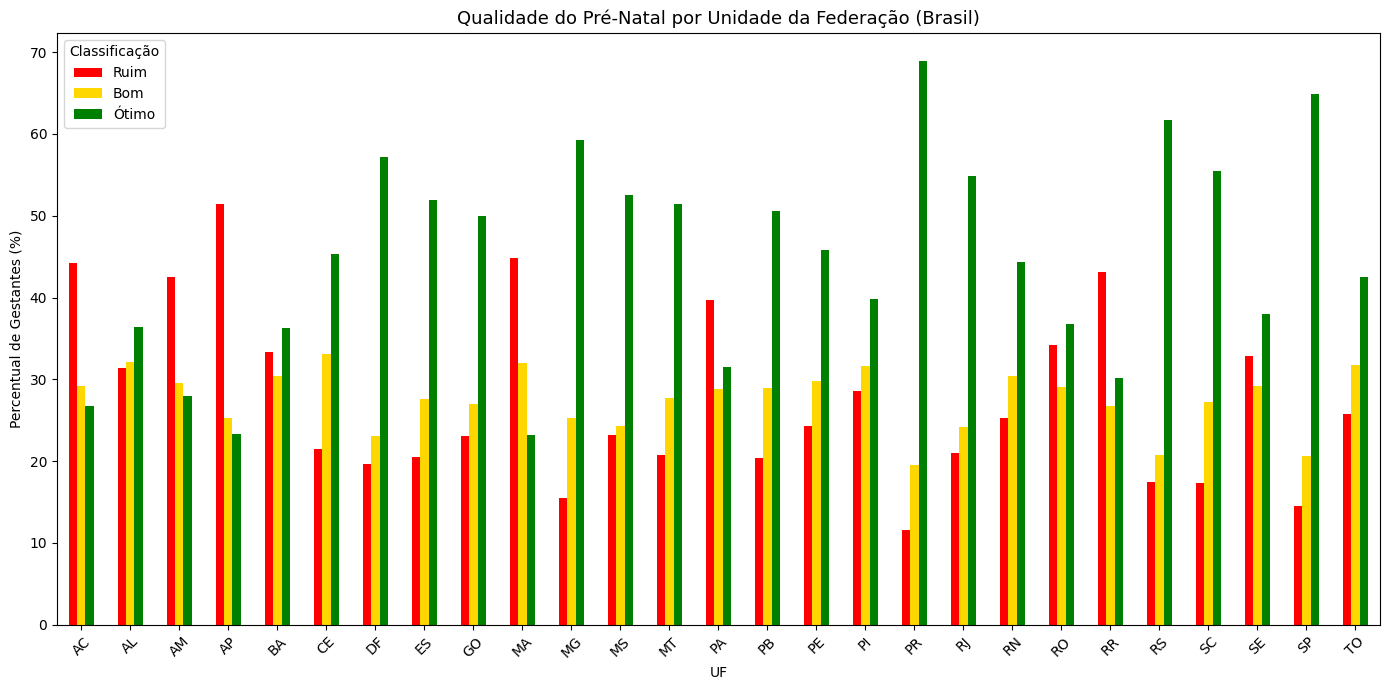

In [26]:
# 7.1 Gráfico – Qualidade do pré-natal por UF (Brasil)

print("\n📊 [UF] Gráfico – Qualidade do pré-natal por estado (Ruim, Bom, Ótimo):")

# Classificação
def classificar_pre_natal(cat):
    if cat in ['Nenhum', 'Inadequado']:
        return 'Ruim'
    elif cat == 'Mínimo':
        return 'Bom'
    elif cat in ['Adequado', 'Incomum']:
        return 'Ótimo'
    return 'Ignorado'

df['GRUPO_PRENATAL'] = df['CATEGORIA_PRENATAL'].apply(classificar_pre_natal)

# Tabela cruzada: UF x Grupo pré-natal
tabela_uf = df.groupby(['UF', 'GRUPO_PRENATAL']).size().unstack().fillna(0)

# Percentuais por UF
tabela_uf_pct = (tabela_uf.T / tabela_uf.sum(axis=1)).T * 100
tabela_uf_pct = tabela_uf_pct[['Ruim', 'Bom', 'Ótimo']].round(2)

# Plotar
tabela_uf_pct.plot(kind='bar', figsize=(14, 7), color=['red', 'gold', 'green'])
plt.title('Qualidade do Pré-Natal por Unidade da Federação (Brasil)', fontsize=13)
plt.ylabel('Percentual de Gestantes (%)')
plt.xlabel('UF')
plt.xticks(rotation=45)
plt.legend(title='Classificação')
plt.tight_layout()
plt.show()


📊 Risco percentual de anomalias fetais por categoria de pré-natal (considerando total de nascidos da categoria):

📊 Tabela de risco de anomalias fetais por categoria de pré-natal:

                    Nascidos Vivos  Com Anomalia  Risco (%)
CATEGORIA_PRENATAL                                         
Adequado                   1463392         10434       0.71
Inadequado                  603795          5131       0.85
Incomum                      63083           710       1.13
Mínimo                      769797          5409       0.70
Nenhum                       79192           600       0.76

📊 [UF] Risco de anomalias fetais por grupo de pré-natal (Ruim, Bom, Ótimo):



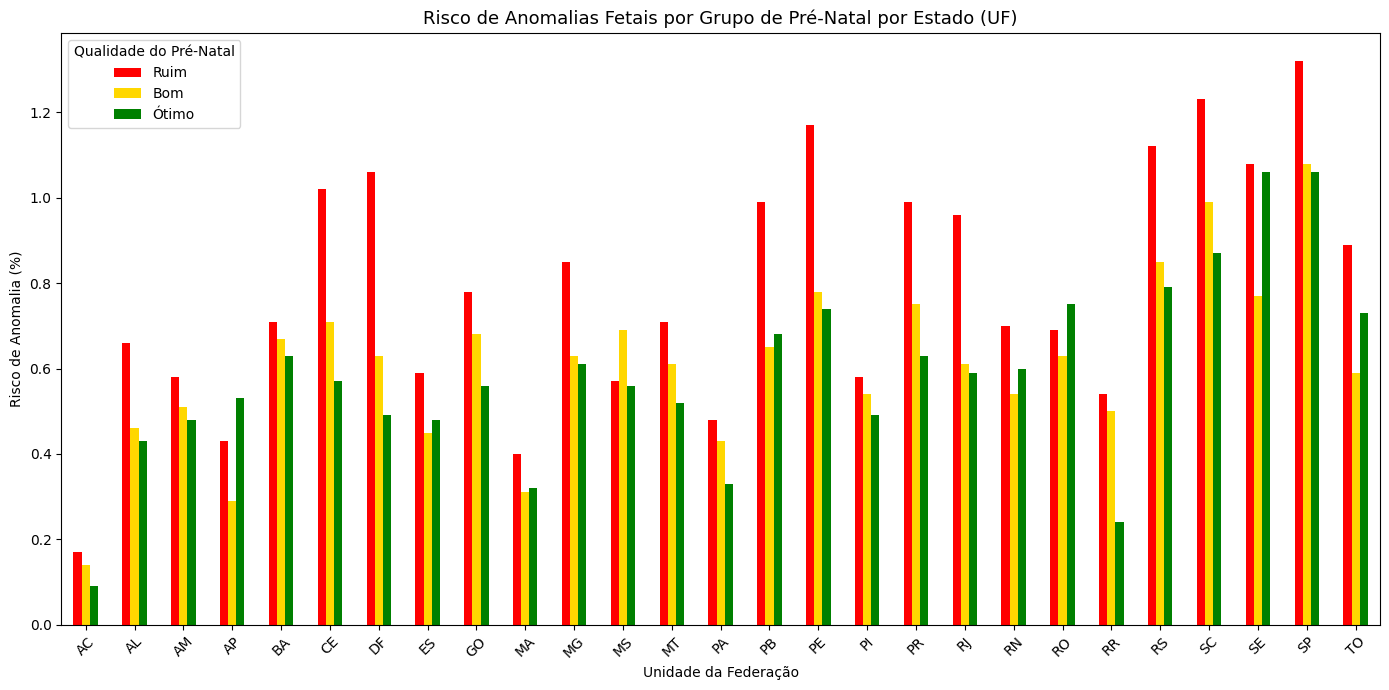

In [27]:
# -----------------------------
# BL.8 Risco percentual de anomalias por categoria de pré-natal
# -----------------------------
print("\n📊 Risco percentual de anomalias fetais por categoria de pré-natal (considerando total de nascidos da categoria):")

total_por_categoria = df['CATEGORIA_PRENATAL'].value_counts().sort_index()
anom_por_categoria = anomalias['CATEGORIA_PRENATAL'].value_counts().sort_index()

risco_categoria = pd.DataFrame({
    'Nascidos Vivos': total_por_categoria,
    'Com Anomalia': anom_por_categoria
}).fillna(0)

risco_categoria['Risco (%)'] = ((risco_categoria['Com Anomalia'] / risco_categoria['Nascidos Vivos']) * 100).round(2)

print("\n📊 Tabela de risco de anomalias fetais por categoria de pré-natal:\n")
print(risco_categoria)

# 8.1 Gráfico – Risco de anomalias por grupo de pré-natal por estado (UF)

print("\n📊 [UF] Risco de anomalias fetais por grupo de pré-natal (Ruim, Bom, Ótimo):\n")

# Classificar
def classificar_pre_natal(cat):
    if cat in ['Nenhum', 'Inadequado']:
        return 'Ruim'
    elif cat == 'Mínimo':
        return 'Bom'
    elif cat in ['Adequado', 'Incomum']:
        return 'Ótimo'
    return 'Ignorado'

df['GRUPO_PRENATAL'] = df['CATEGORIA_PRENATAL'].apply(classificar_pre_natal)

# Apenas registros válidos
df_validos = df[(df['GRUPO_PRENATAL'] != 'Ignorado') & (df['UF'].notna())]

# Estrutura para armazenar os resultados
dados = []

# Iterar por UF e grupo
for uf in sorted(df_validos['UF'].unique()):
    for grupo in ['Ruim', 'Bom', 'Ótimo']:
        sub = df_validos[(df_validos['UF'] == uf) & (df_validos['GRUPO_PRENATAL'] == grupo)]
        total = len(sub)
        if total > 0:
            anomalias = (sub['IDANOMAL'].astype(float) == 1).sum()
            risco = round((anomalias / total) * 100, 2)
        else:
            risco = 0.0
        dados.append({'UF': uf, 'Grupo': grupo, 'Risco (%)': risco})

# Transformar
df_risco = pd.DataFrame(dados)
df_risco_pivot = df_risco.pivot(index='UF', columns='Grupo', values='Risco (%)')[['Ruim', 'Bom', 'Ótimo']]

# Plota o gráfico
df_risco_pivot.plot(kind='bar', figsize=(14, 7), color=['red', 'gold', 'green'])
plt.title('Risco de Anomalias Fetais por Grupo de Pré-Natal por Estado (UF)', fontsize=13)
plt.ylabel('Risco de Anomalia (%)')
plt.xlabel('Unidade da Federação')
plt.xticks(rotation=45)
plt.legend(title='Qualidade do Pré-Natal')
plt.tight_layout()
plt.show()

In [28]:
# -----------------------------
# BL.9 Risco de anomalias fetais por categoria de pré-natal – somente mães com 36 anos ou mais (Brasil)
# -----------------------------

print("\n📊 [BRASIL] Risco de anomalias fetais por categoria de pré-natal – mães com 36 anos ou mais:\n")

# Filtrar as faixas de risco
faixas_risco = ['36-40', '>=41']
df_risco_idade = df[df['FAIXA_ETARIA'].isin(faixas_risco)]

# Separar anomalias confirmadas
df_risco_idade_anom = df_risco_idade[df_risco_idade['IDANOMAL'].astype(float) == 1]

# Total de mães com mais de 36 por categoria de pré-natal
total_por_categoria = df_risco_idade['CATEGORIA_PRENATAL'].value_counts().sort_index()

# Total de anomalias confirmadas por categoria
anomalias_por_categoria = df_risco_idade_anom['CATEGORIA_PRENATAL'].value_counts().sort_index()

# Tabela de risco
tabela_risco = pd.DataFrame({
    'Gestantes 36+': total_por_categoria,
    'Com Anomalia': anomalias_por_categoria
}).fillna(0)

tabela_risco['Risco (%)'] = (tabela_risco['Com Anomalia'] / tabela_risco['Gestantes 36+'] * 100).round(2)

# Exibe essa tabela
print(tabela_risco.astype({'Gestantes 36+': 'int', 'Com Anomalia': 'int', 'Risco (%)': 'float'}))


📊 [BRASIL] Risco de anomalias fetais por categoria de pré-natal – mães com 36 anos ou mais:

                    Gestantes 36+  Com Anomalia  Risco (%)
CATEGORIA_PRENATAL                                        
Adequado                   156873          1575       1.00
Inadequado                  43968           560       1.27
Incomum                      8839           120       1.36
Mínimo                      64417           648       1.01
Nenhum                       7420            87       1.17


In [ ]:
# 9.1 Risco de anomalias fetais por categoria de pre-natal – mães com 36 anos ou mais (SP)

print("\n📊 [SP] Risco de anomalias fetais por categoria de pré-natal – mães com 36 anos ou mais:\n")

# Filtrar São Paulo com faixas etárias de risco
df_sp_risco = df[(df['UF'] == 'SP') & (df['FAIXA_ETARIA'].isin(['36-40', '>=41']))]

# Anomalias confirmadas
df_sp_risco_anom = df_sp_risco[df_sp_risco['IDANOMAL'].astype(str) == '1']

# Contagem total nas categorias
total_sp_categoria = df_sp_risco['CATEGORIA_PRENATAL'].value_counts().sort_index()

# Contagem de anomalias nas categoria
anomalias_sp_categoria = df_sp_risco_anom['CATEGORIA_PRENATAL'].value_counts().sort_index()

# Construir a tabela de risco
tabela_sp_risco = pd.DataFrame({
    'Gestantes 36+ (SP)': total_sp_categoria,
    'Com Anomalia': anomalias_sp_categoria
}).fillna(0)

tabela_sp_risco['Risco (%)'] = (tabela_sp_risco['Com Anomalia'] / tabela_sp_risco['Gestantes 36+ (SP)'] * 100).round(2)

# Exibi
print(tabela_sp_risco.astype({'Gestantes 36+ (SP)': 'int', 'Com Anomalia': 'int', 'Risco (%)': 'float'}))


📊 [BRASIL] Comparação do risco de anomalias entre gestantes com mais de 36 anos por tipo de acompanhamento pré-natal (gráfico de barras):


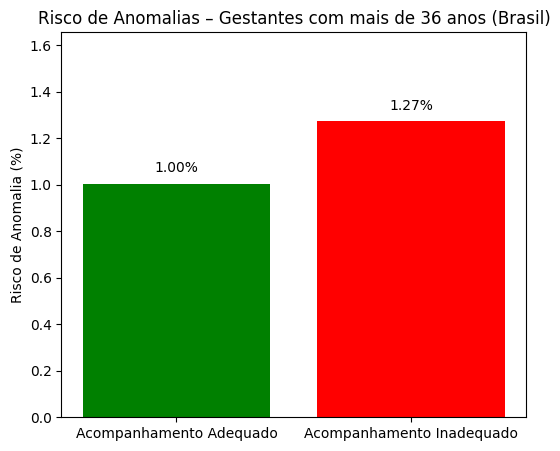

In [29]:
# 9.2 Gráfico de barras – Risco de anomalias em gestantes com mais de 36 anos (Brasil)

print("\n📊 [BRASIL] Comparação do risco de anomalias entre gestantes com mais de 36 anos por tipo de acompanhamento pré-natal (gráfico de barras):")

# Dados
riscos_brasil = {
    'Acompanhamento Adequado': 1575 / 156873 * 100,
    'Acompanhamento Inadequado': 560 / 43968 * 100
}

labels = list(riscos_brasil.keys())
values = list(riscos_brasil.values())

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=['green', 'red'])
plt.title('Risco de Anomalias – Gestantes com mais de 36 anos (Brasil)')
plt.ylabel('Risco de Anomalia (%)')

# Exibi valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}%', ha='center')

plt.ylim(0, max(values) * 1.3)
plt.show()



📊 [SP] Comparação do risco de anomalias entre gestantes com mais de 36 anos por tipo de acompanhamento pré-natal (gráfico de barras):


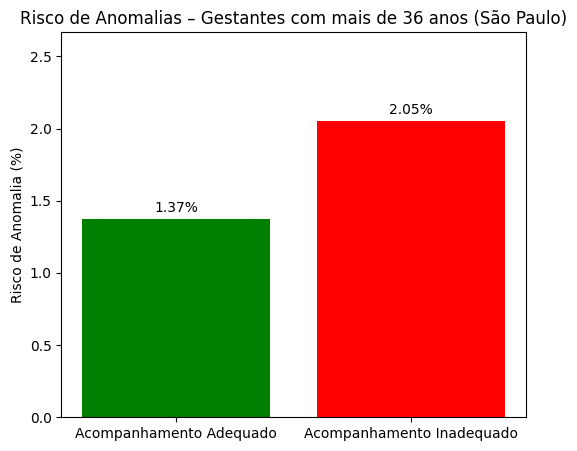

In [30]:
# 9.3 Gráfico de barras – Risco de anomalias em gestantes com mais de 36 anos (São Paulo)

print("\n📊 [SP] Comparação do risco de anomalias entre gestantes com mais de 36 anos por tipo de acompanhamento pré-natal (gráfico de barras):")

riscos_sp = {
    'Acompanhamento Adequado': 657 / 47893 * 100,
    'Acompanhamento Inadequado': 155 / 7556 * 100
}

labels = list(riscos_sp.keys())
values = list(riscos_sp.values())

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=['green', 'red'])
plt.title('Risco de Anomalias – Gestantes com mais de 36 anos (São Paulo)')
plt.ylabel('Risco de Anomalia (%)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}%', ha='center')

plt.ylim(0, max(values) * 1.3)
plt.show()

In [38]:
# -----------------------------
# BL.10 Distribuição percentual das categorias de pré-natal por escolaridade (Brasil e por UF)
# -----------------------------

# Para mapear escolaridade
escolaridade_dict = {
    1: '0 anos',
    2: '1-3 anos',
    3: '4-7 anos',
    4: '8-11 anos',
    5: '12+ anos',
    9: 'N/I'
}
df['ESCMAE_LABEL'] = df['ESCMAE'].astype(float).map(escolaridade_dict).fillna('N/I')

ordem_escolaridade = ['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos', 'N/I']

# 📊 Nacional — distribuição de categorias de pré-natal dentro de cada faixa de escolaridade
print("\n📊 Distribuição percentual das categorias de pré-natal dentro de cada faixa de escolaridade (Brasil):")

tabela_nacional = (
    df.groupby('ESCMAE_LABEL')['CATEGORIA_PRENATAL']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(4) * 100
)

tabela_nacional = tabela_nacional.reindex(index=ordem_escolaridade)
print(tabela_nacional.round(2).astype(str) + " %")

# 📊 Por estado (UF)
print("\n📊 Distribuição percentual das categorias de pré-natal dentro de cada faixa de escolaridade (por estado):")

tabela_uf = (
    df.groupby(['UF', 'ESCMAE_LABEL'])['CATEGORIA_PRENATAL']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(4) * 100
)

ufs = sorted(df['UF'].dropna().unique())
for uf in ufs:
    print(f"\n📌 {uf} — Distribuição % das categorias de pré-natal por escolaridade:")
    tabela_estado = tabela_uf.loc[uf].reindex(index=ordem_escolaridade)
    print(tabela_estado.round(2).astype(str) + " %")


📊 Distribuição percentual das categorias de pré-natal dentro de cada faixa de escolaridade (Brasil):
CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo   Nenhum
ESCMAE_LABEL                                                    
0 anos              19.96 %    43.34 %  1.89 %  23.66 %  11.15 %
1-3 anos            31.65 %    33.42 %  1.57 %  27.72 %   5.64 %
4-7 anos            36.46 %    30.16 %  1.61 %  27.97 %    3.8 %
8-11 anos           49.65 %     19.4 %  1.85 %  27.12 %   1.98 %
12+ anos            67.68 %     8.12 %  3.67 %  18.78 %   1.75 %
N/I                 36.24 %     22.5 %  2.47 %  26.43 %  12.36 %

📊 Distribuição percentual das categorias de pré-natal dentro de cada faixa de escolaridade (por estado):

📌 AC — Distribuição % das categorias de pré-natal por escolaridade:
CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo   Nenhum
ESCMAE_LABEL                                                    
0 anos               7.24 %    57.18 %  0.86 %  15.09 %  19.63 %
1-3 anos


📊 [BRASIL] Gráfico – Qualidade do pré-natal por escolaridade (Ruim, Bom, Ótimo):


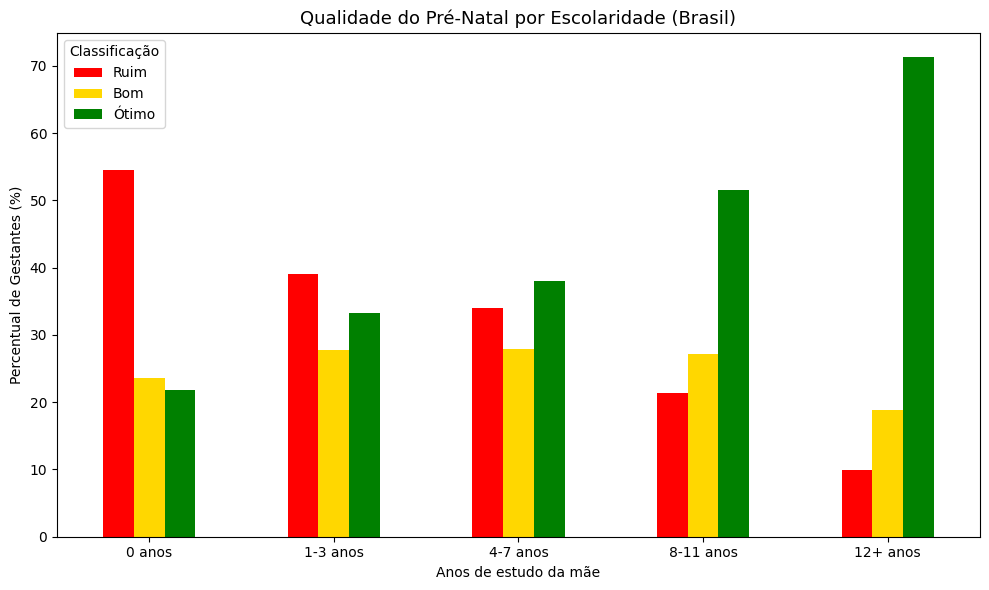

In [39]:
# 10.1 Gráfico – Qualidade do pré-natal por escolaridade (Brasil)

print("\n📊 [BRASIL] Gráfico – Qualidade do pré-natal por escolaridade (Ruim, Bom, Ótimo):")

# Classificação em grupos
def classificar_pre_natal(cat):
    if cat in ['Nenhum', 'Inadequado']:
        return 'Ruim'
    elif cat == 'Mínimo':
        return 'Bom'
    elif cat in ['Adequado', 'Incomum']:
        return 'Ótimo'
    return 'Ignorado'

df['GRUPO_PRENATAL'] = df['CATEGORIA_PRENATAL'].apply(classificar_pre_natal)

# Remover registros dos N/I
df_validos = df[(df['ESCMAE_LABEL'] != 'N/I') & (df['GRUPO_PRENATAL'] != 'Ignorado')]

# Agrupa e calcula os percentuais
ordem_escolaridade_sem_ni = ['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos']
tabela_esc = df_validos.groupby(['ESCMAE_LABEL', 'GRUPO_PRENATAL']).size().unstack().fillna(0)
tabela_esc = tabela_esc.reindex(index=ordem_escolaridade_sem_ni)

tabela_pct = (tabela_esc.T / tabela_esc.sum(axis=1)).T * 100
tabela_pct = tabela_pct[['Ruim', 'Bom', 'Ótimo']].round(2)

# Plota
tabela_pct.plot(kind='bar', figsize=(10, 6), color=['red', 'gold', 'green'])
plt.title('Qualidade do Pré-Natal por Escolaridade (Brasil)', fontsize=13)
plt.ylabel('Percentual de Gestantes (%)')
plt.xlabel('Anos de estudo da mãe')
plt.xticks(rotation=0)
plt.legend(title='Classificação')
plt.tight_layout()
plt.show()

In [40]:
# -----------------------------
# BL.11 Distribuição racial das gestantes – Brasil e por estado (UF)
# -----------------------------
def agrupar_raca(valor):
    try:
        codigo = int(valor)
        if codigo in [2, 4]:
            return 'Pretos e Pardos'
        elif codigo in [1, 3]:
            return 'Brancos e Amarelos'
        elif codigo == 5:
            return 'Indígenas'
        else:
            return 'Ignorado'
    except:
        return 'Ignorado'

df['GRUPO_RACIAL'] = df['RACACOR'].apply(agrupar_raca)
df_validos_raca = df[df['GRUPO_RACIAL'] != 'Ignorado']

# Nacional
contagem_racial = df_validos_raca['GRUPO_RACIAL'].value_counts().sort_index()
percentual_racial = (contagem_racial / len(df_validos_raca)) * 100

print("\n📊 Distribuição racial das gestantes (Brasil):\n")
for grupo in contagem_racial.index:
    total = contagem_racial[grupo]
    perc = percentual_racial[grupo]
    print(f"{grupo:<22} {total:>7}  ({perc:.2f}%)")

# Por estado
print("\n📊 Distribuição racial por estado (absoluto e percentual):\n")

colunas_ordenadas = ['Brancos e Amarelos', 'Pretos e Pardos', 'Indígenas']

tabela_abs = (
    df_validos_raca.groupby(['UF', 'GRUPO_RACIAL'])
    .size()
    .unstack()
    .reindex(columns=colunas_ordenadas, fill_value=0)
    .astype(int)
)

tabela_pct = (
    tabela_abs.div(tabela_abs.sum(axis=1), axis=0) * 100
).round(2)

# Formatação final da tabela
tabela_final = tabela_abs.astype(str) + " (" + tabela_pct.astype(str) + "%)"
print(tabela_final.to_string())


📊 Distribuição racial das gestantes (Brasil):

Brancos e Amarelos     1080066  (37.79%)
Indígenas                23017  (0.81%)
Pretos e Pardos        1754891  (61.40%)

📊 Distribuição racial por estado (absoluto e percentual):

GRUPO_RACIAL Brancos e Amarelos  Pretos e Pardos     Indígenas
UF                                                            
AC                 1243 (7.85%)   13733 (86.78%)   849 (5.36%)
AL                 3323 (6.73%)   45922 (92.99%)   139 (0.28%)
AM                 3834 (4.78%)   69841 (87.16%)  6455 (8.06%)
AP                1653 (10.49%)   13803 (87.58%)   305 (1.94%)
BA                17958 (9.57%)  168993 (90.05%)   713 (0.38%)
CE                11981 (10.7%)    99786 (89.1%)    227 (0.2%)
DF                9905 (29.06%)   24125 (70.78%)    55 (0.16%)
ES               14995 (27.42%)   39555 (72.34%)   130 (0.24%)
GO               25787 (29.44%)   61725 (70.47%)    82 (0.09%)
MA               11423 (10.46%)   96533 (88.38%)  1273 (1.17%)
MG            


📊 [BRASIL] Gráfico de pizza – Distribuição racial das gestantes (total nacional com raça informada):


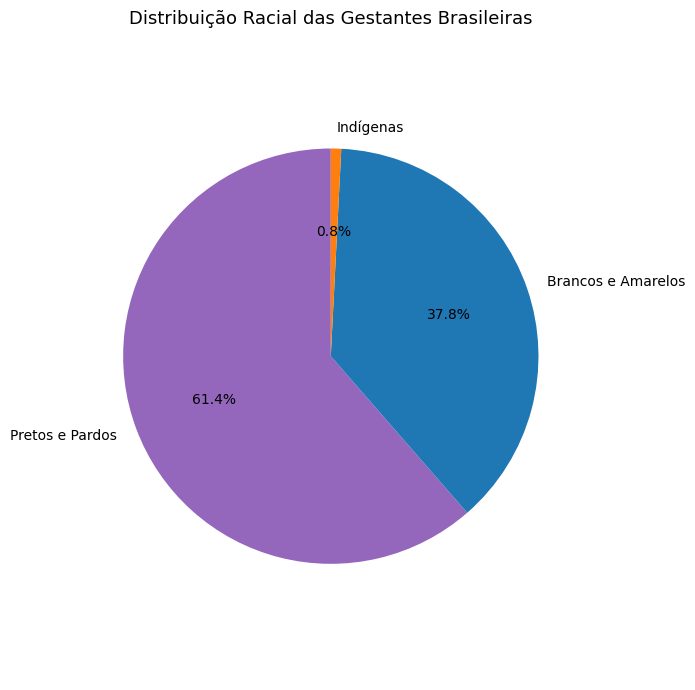

In [41]:
# 11.1 Gráfico de pizza – Distribuição racial das gestantes (Brasil)

print("\n📊 [BRASIL] Gráfico de pizza – Distribuição racial das gestantes (total nacional com raça informada):")

# Dados
labels = ['Pretos e Pardos', 'Brancos e Amarelos', 'Indígenas']
values = [contagem_racial.get(label, 0) for label in labels]
colors = ['#9467bd', '#1f77b4', '#ff7f0e']  # roxo, azul, laranja

# Plot
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição Racial das Gestantes Brasileiras', fontsize=13)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [42]:
# -----------------------------
# BL.12 Distribuição do estado civil das gestantes – Brasil e por estado (UF)
# -----------------------------

def agrupar_estado_civil(valor):
    try:
        codigo = int(valor)
        if codigo in [1, 2]:
            return 'Não solo'
        elif codigo in [3, 4, 5]:
            return 'Solo'
        else:
            return 'N/I'
    except:
        return 'N/I'

df['GRUPO_ESTCIVIL'] = df['ESTCIVMAE'].apply(agrupar_estado_civil)
df_validos_civil = df[df['GRUPO_ESTCIVIL'] != 'N/I']

# Nacional
contagem_civil = df_validos_civil['GRUPO_ESTCIVIL'].value_counts().sort_index()
percentual_civil = (contagem_civil / len(df_validos_civil)) * 100

print("\n📊 Distribuição do estado civil das gestantes (Brasil):\n")
for grupo in contagem_civil.index:
    total = contagem_civil[grupo]
    perc = percentual_civil[grupo]
    print(f"{grupo:<20} {total:>7}  ({perc:.2f}%)")

# Por estado
print("\n📊 Distribuição por estado (absoluto e percentual):\n")

colunas_ordenadas = ['Não solo', 'Solo']

# Cálculo
tabela_abs = (
    df_validos_civil.groupby(['UF', 'GRUPO_ESTCIVIL'])
    .size()
    .unstack()
    .reindex(columns=colunas_ordenadas, fill_value=0)
    .astype(int)
)

tabela_pct = (
    tabela_abs.div(tabela_abs.sum(axis=1), axis=0) * 100
).round(2)

# Formatação final
tabela_final = tabela_abs.astype(str) + " (" + tabela_pct.astype(str) + "%)"
print(tabela_final.to_string())


📊 Distribuição do estado civil das gestantes (Brasil):

Não solo             2175361  (73.86%)
Solo                  770021  (26.14%)

📊 Distribuição por estado (absoluto e percentual):

GRUPO_ESTCIVIL         Não solo             Solo
UF                                              
AC                6941 (40.99%)    9991 (59.01%)
AL               30204 (59.31%)   20719 (40.69%)
AM               56426 (70.32%)   23819 (29.68%)
AP                6421 (40.49%)    9438 (59.51%)
BA              140740 (70.83%)   57961 (29.17%)
CE               90419 (71.35%)   36313 (28.65%)
DF               34742 (79.07%)    9199 (20.93%)
ES               45191 (80.65%)   10843 (19.35%)
GO               72289 (73.69%)   25806 (26.31%)
MA               71791 (62.37%)   43310 (37.63%)
MG              219765 (83.25%)   44209 (16.75%)
MS               35300 (80.48%)    8560 (19.52%)
MT               31373 (55.98%)   24671 (44.02%)
PA               65536 (46.43%)   75616 (53.57%)
PB               38907 (69.2


📊 [BRASIL] Gráfico de pizza – Estado civil das gestantes:


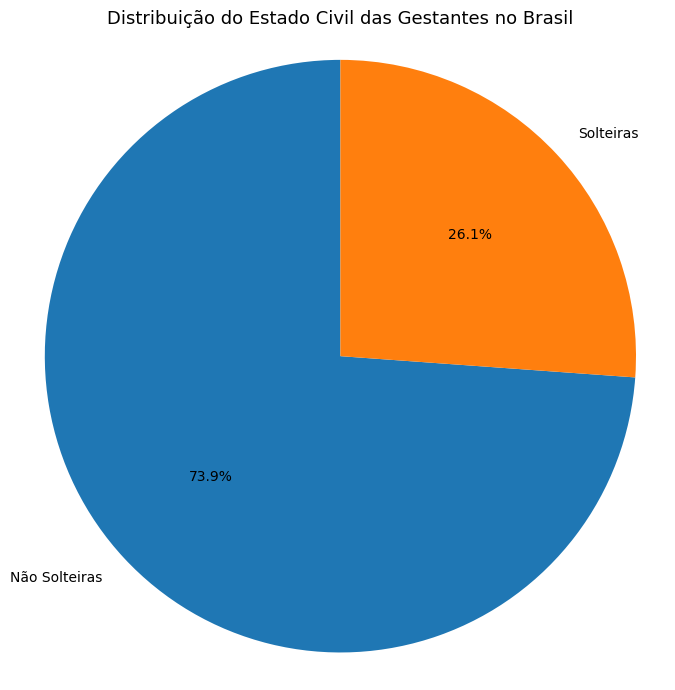

In [43]:
# 12.1 Gráfico de pizza – Estado civil das gestantes (Brasil)

print("\n📊 [BRASIL] Gráfico de pizza – Estado civil das gestantes:")

labels = ['Não Solteiras', 'Solteiras']
values = [
    contagem_civil.get('Não solo', 0),
    contagem_civil.get('Solo', 0)
]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição do Estado Civil das Gestantes no Brasil', fontsize=13)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [44]:
# -----------------------------
# BL.13 Distribuição das categorias de pré-natal por grupo racial – Brasil
# -----------------------------

# para remover os ignorados
df_raca_prenatal = df[df['GRUPO_RACIAL'] != 'Ignorado']

# Cruzamento
tabela_cruzada_raca = (
    df_raca_prenatal.groupby('GRUPO_RACIAL')['CATEGORIA_PRENATAL']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(4) * 100
)

# Formatação para exibir com porcentagens
print("\n📊 Distribuição percentual das categorias de pré-natal por grupo racial (Brasil):\n")
print(tabela_cruzada_raca.round(2).astype(str) + " %")


📊 Distribuição percentual das categorias de pré-natal por grupo racial (Brasil):

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo  Nenhum
GRUPO_RACIAL                                                   
Brancos e Amarelos  61.48 %     12.6 %  2.88 %  21.65 %   1.4 %
Indígenas           18.31 %    47.23 %  1.21 %  25.56 %  7.69 %
Pretos e Pardos     42.43 %    24.64 %  1.65 %  28.36 %  2.91 %



📊 [BRASIL] Gráfico – Qualidade do pré-natal por grupo racial (Ruim, Bom, Ótimo):


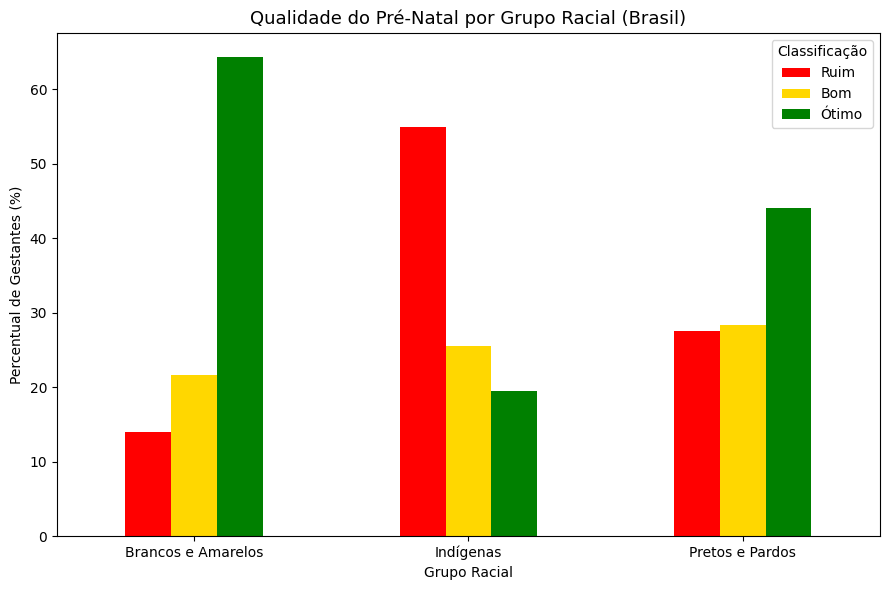

In [45]:
# 13.1 Gráfico – Qualidade do pré-natal por grupo racial (Brasil)

print("\n📊 [BRASIL] Gráfico – Qualidade do pré-natal por grupo racial (Ruim, Bom, Ótimo):")

# Categorias em grupos
def classificar_pre_natal(cat):
    if cat in ['Nenhum', 'Inadequado']:
        return 'Ruim'
    elif cat == 'Mínimo':
        return 'Bom'
    elif cat in ['Adequado', 'Incomum']:
        return 'Ótimo'
    return 'Ignorado'

df['GRUPO_PRENATAL'] = df['CATEGORIA_PRENATAL'].apply(classificar_pre_natal)

# Apenas grupos raciais analisados no bloco 13
grupos_raciais = ['Pretos e Pardos', 'Brancos e Amarelos', 'Indígenas']
df_racial = df[df['GRUPO_RACIAL'].isin(grupos_raciais)]

# Tabela cruzada
tabela = df_racial.groupby(['GRUPO_RACIAL', 'GRUPO_PRENATAL']).size().unstack().fillna(0)

# Percentual por grupo racial
tabela_pct = (tabela.T / tabela.sum(axis=1)).T * 100
tabela_pct = tabela_pct[['Ruim', 'Bom', 'Ótimo']].round(2)

# Plotar
tabela_pct.plot(kind='bar', figsize=(9, 6), color=['red', 'gold', 'green'])
plt.title('Qualidade do Pré-Natal por Grupo Racial (Brasil)', fontsize=13)
plt.ylabel('Percentual de Gestantes (%)')
plt.xlabel('Grupo Racial')
plt.xticks(rotation=0)
plt.legend(title='Classificação')
plt.tight_layout()
plt.show()

In [46]:
# -----------------------------
# BL.14 Distribuição das categorias de pré-natal por grupo racial e escolaridade – Brasil
# -----------------------------

# Filtrar só válidos
df_raca_esc = df[
    (df['GRUPO_RACIAL'] != 'Ignorado') &
    (df['ESCMAE_LABEL'] != 'NL')
]

# Ordem das faixas de escolaridade
ordem_escolaridade = ['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos', 'N/I']

# Agrupar: raça + escolaridade e categoria pré-natal
tabela_cruzada = (
    df_raca_esc
    .groupby(['GRUPO_RACIAL', 'ESCMAE_LABEL'])['CATEGORIA_PRENATAL']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(4) * 100
)

# Precisou reordenar
tabela_cruzada = tabela_cruzada.reindex(index=ordem_escolaridade, level=1)

# Exibe o formatado
print("\n📊 Distribuição percentual das categorias de pré-natal por grupo racial e escolaridade (Brasil):\n")

# Separar por grupo racial
for grupo in sorted(df_raca_esc['GRUPO_RACIAL'].unique()):
    print(f"\n📌 {grupo}:\n")
    print(tabela_cruzada.loc[grupo].round(2).astype(str) + " %")



📊 Distribuição percentual das categorias de pré-natal por grupo racial e escolaridade (Brasil):


📌 Brancos e Amarelos:

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo  Nenhum
ESCMAE_LABEL                                                   
0 anos              34.45 %    30.43 %  1.81 %  27.04 %  6.28 %
1-3 anos            45.43 %    22.67 %  2.06 %  26.59 %  3.25 %
4-7 anos             48.2 %    21.75 %  2.06 %  25.77 %  2.23 %
8-11 anos           58.98 %    13.78 %  2.37 %  23.61 %  1.27 %
12+ anos            73.08 %     5.76 %  4.23 %  15.87 %  1.06 %
N/I                 52.54 %    15.55 %  2.82 %   24.2 %  4.89 %

📌 Indígenas:

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo   Nenhum
ESCMAE_LABEL                                                    
0 anos               4.95 %    61.55 %  1.25 %  14.62 %  17.63 %
1-3 anos            10.88 %    53.65 %  1.37 %  23.96 %  10.14 %
4-7 anos            16.38 %    49.13 %  1.06 %  26.92 %   6.51 %
8-11 anos            27.8 

In [47]:
# -----------------------------
# BL.15 Distribuição das categorias de pré-natal por grupo racial, escolaridade e estado civil – Brasil
# -----------------------------

# Filtrar só válidos
df_raca_esc_civil = df[
    (df['GRUPO_RACIAL'] != 'Ignorado') &
    (df['ESCMAE_LABEL'] != 'NL') &
    (df['GRUPO_ESTCIVIL'] != 'N/I')
]

# Ordem da escolaridade
ordem_escolaridade = ['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos', 'N/I']

# Agrupar raça/escolaridade/prenatal/EstadoCivil
tabela_cruzada = (
    df_raca_esc_civil
    .groupby(['GRUPO_RACIAL', 'ESCMAE_LABEL', 'GRUPO_ESTCIVIL'])['CATEGORIA_PRENATAL']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .round(4) * 100
)

# Reordenar escolaridade dentro de cada grupo
tabela_cruzada = tabela_cruzada.reindex(index=pd.MultiIndex.from_product(
    [
        sorted(df_raca_esc_civil['GRUPO_RACIAL'].unique()),
        ordem_escolaridade,
        sorted(df_raca_esc_civil['GRUPO_ESTCIVIL'].unique())
    ],
    names=['GRUPO_RACIAL', 'ESCMAE_LABEL', 'GRUPO_ESTCIVIL']
)).dropna(how='all')

# Exibir
print("\n📊 Distribuição percentual das categorias de pré-natal por grupo racial, escolaridade e estado civil (Brasil):\n")

# Iterar por grupo racial
for grupo_racial in sorted(df_raca_esc_civil['GRUPO_RACIAL'].unique()):
    print(f"\n📌 {grupo_racial}:\n")
    grupo_df = tabela_cruzada.loc[grupo_racial]
    for estado_civil in sorted(df_raca_esc_civil['GRUPO_ESTCIVIL'].unique()):
        print(f"▶ Estado civil: {estado_civil}\n")
        subtabela = grupo_df.xs(estado_civil, level='GRUPO_ESTCIVIL', drop_level=False)
        print((subtabela.droplevel('GRUPO_ESTCIVIL').round(2).astype(str) + " %").to_string())


📊 Distribuição percentual das categorias de pré-natal por grupo racial, escolaridade e estado civil (Brasil):


📌 Brancos e Amarelos:

▶ Estado civil: Não solo

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo  Nenhum
ESCMAE_LABEL                                                   
0 anos              35.58 %    29.27 %  1.84 %  26.91 %   6.4 %
1-3 anos            46.08 %    21.69 %  2.32 %   26.4 %   3.5 %
4-7 anos            48.32 %    21.59 %  2.18 %  25.51 %  2.41 %
8-11 anos           59.56 %    13.34 %  2.44 %  23.35 %   1.3 %
12+ anos            73.88 %     5.37 %  4.35 %  15.35 %  1.06 %
N/I                 54.24 %    14.74 %  2.84 %  23.52 %  4.66 %
▶ Estado civil: Solo

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo  Nenhum
ESCMAE_LABEL                                                   
0 anos              32.56 %    32.89 %  1.83 %  27.08 %  5.65 %
1-3 anos            44.07 %    24.81 %  1.48 %  27.04 %  2.61 %
4-7 anos            47.93 %    22.16 %  1.76 %  

In [48]:
# -----------------------------
# Bl.16 Distribuição percentual das categorias de pré-natal por grupo racial, escolaridade, estado civil e faixa etária (Brasil)
# -----------------------------

print("\n📊 Distribuição percentual das categorias de pré-natal por grupo racial, escolaridade, estado civil e faixa etária (Brasil):\n")

# Filtrar apenas registros válidos
df_validos_full = df[
    (df['GRUPO_RACIAL'].isin(['Brancos e Amarelos', 'Pretos e Pardos', 'Indígenas'])) &
    (df['ESCMAE_LABEL'].isin(['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos', 'N/I'])) &
    (df['GRUPO_ESTCIVIL'].isin(['Solo', 'Não solo'])) &
    (df['FAIXA_ETARIA'].isin(['<=13', '14-18', '19-30', '31-35', '36-40', '>=41']))
]

# Defini a ordem fixa/escolaridade
ordem_escolaridade = ['0 anos', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos', 'N/I']

# Loop por grupo racial
for grupo_racial in df_validos_full['GRUPO_RACIAL'].unique():
    print(f"\n📌 {grupo_racial}:\n")
    # Loop por estado civil
    for estado_civil in ['Não solo', 'Solo']:
        print(f"▶ Estado civil: {estado_civil}\n")
        # Loop por faixa etária
        for faixa in ['<=13', '14-18', '19-30', '31-35', '36-40', '>=41']:
            print(f"📎 Faixa etária: {faixa}\n")
            # Filtrar dados
            dados = df_validos_full[
                (df_validos_full['GRUPO_RACIAL'] == grupo_racial) &
                (df_validos_full['GRUPO_ESTCIVIL'] == estado_civil) &
                (df_validos_full['FAIXA_ETARIA'] == faixa)
            ]
            if len(dados) == 0:
                print("❗ Sem dados para esta combinação.\n")
                continue
            # Agrupa e calcula os percentuais
            tabela_pct = (
                    dados.groupby('ESCMAE_LABEL')['CATEGORIA_PRENATAL']
                    .value_counts(normalize=True)
                    .unstack()
                    .fillna(0)
                    .round(4) * 100
            )
            tabela_pct = tabela_pct.reindex(index=ordem_escolaridade)

            # ✅ Corrigir para 2 casas decimais
            tabela_pct = tabela_pct.astype(float).round(2).astype(str) + " %"

            # Exibi
            print(tabela_pct.to_string())
            print()



📊 Distribuição percentual das categorias de pré-natal por grupo racial, escolaridade, estado civil e faixa etária (Brasil):


📌 Pretos e Pardos:

▶ Estado civil: Não solo

📎 Faixa etária: <=13

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo   Nenhum
ESCMAE_LABEL                                                    
0 anos              22.22 %    33.33 %   0.0 %  33.33 %  11.11 %
1-3 anos            20.38 %    45.97 %   0.0 %  25.59 %   8.06 %
4-7 anos            26.13 %    40.52 %  1.12 %  27.83 %    4.4 %
8-11 anos           31.41 %     36.8 %  2.12 %  26.78 %   2.89 %
12+ anos              nan %      nan %   nan %    nan %    nan %
N/I                 22.81 %    33.33 %  3.51 %  21.05 %   19.3 %

📎 Faixa etária: 14-18

CATEGORIA_PRENATAL Adequado Inadequado Incomum   Mínimo   Nenhum
ESCMAE_LABEL                                                    
0 anos               15.7 %    44.84 %  3.14 %   22.2 %  14.13 %
1-3 anos             21.8 %    43.36 %  1.27 %  26.93 %   6.64 %
4

In [49]:
# -----------------------------
# BL.17. Percentual nacional de gestantes que não realizaram nenhum pré-natal
# -----------------------------

print("\n📊 [BRASIL] Percentual de gestantes que não realizaram nenhum pré-natal:\n")

# Total nacional
total_gestantes = len(df)

# Total de gestantes sem pré-natal
sem_prenatal = (df['CATEGORIA_PRENATAL'] == 'Nenhum').sum()

# Cálculo do percentual
percentual_sem_prenatal = round((sem_prenatal / total_gestantes) * 100, 2)

print(f"Total de gestantes: {total_gestantes}")
print(f"Gestantes sem nenhum pré-natal: {sem_prenatal}")
print(f"📌 Percentual nacional sem pré-natal: {percentual_sem_prenatal:.2f}%")


📊 [BRASIL] Percentual de gestantes que não realizaram nenhum pré-natal:

Total de gestantes: 2979259
Gestantes sem nenhum pré-natal: 79192
📌 Percentual nacional sem pré-natal: 2.66%


In [50]:
# -----------------------------
# BL.18 Estados com maior concentração de gestantes com baixa escolaridade, negras/indígenas, até 18 anos e solteiras
# -----------------------------

print("\n📊 [BRASIL] Percentual de gestantes em situação de maior vulnerabilidade por estado (perfil combinado):\n")

# Filtrar gestantes válidas para todos os critérios
df_validos_criticos = df[
    (df['ESCMAE_LABEL'].isin(['0 anos', '1-3 anos', '4-7 anos'])) &
    (df['GRUPO_RACIAL'].isin(['Pretos e Pardos', 'Indígenas'])) &
    (df['FAIXA_ETARIA'].isin(['<=13', '14-18'])) &
    (df['GRUPO_ESTCIVIL'] == 'Solo')
]

# Total de gestantes por estado
total_uf = df['UF'].value_counts().sort_index()

# Total com perfil crítico por estado
criticos_uf = df_validos_criticos['UF'].value_counts().sort_index()

# Junta e calcula o percentual
tabela_criticos = pd.DataFrame({
    'Total Gestantes': total_uf,
    'Com Perfil Crítico': criticos_uf
}).fillna(0).astype(int)

tabela_criticos['Percentual (%)'] = (tabela_criticos['Com Perfil Crítico'] / tabela_criticos['Total Gestantes'] * 100).round(2)

# Ordenar por percentual decrescente
tabela_criticos = tabela_criticos.sort_values(by='Percentual (%)', ascending=False)

# Exibir
print(tabela_criticos)


📊 [BRASIL] Percentual de gestantes em situação de maior vulnerabilidade por estado (perfil combinado):

    Total Gestantes  Com Perfil Crítico  Percentual (%)
UF                                                     
PA           143503                8415            5.86
AC            17139                 983            5.74
SE            34369                1771            5.15
AL            51859                2426            4.68
AP            16271                 600            3.69
RO            27560                 843            3.06
PI            47941                1463            3.05
MA           117071                3141            2.68
RN            48111                1267            2.63
BA           204034                4503            2.21
AM            81145                1777            2.19
PE           143489                2800            1.95
PB            57535                 999            1.74
TO            24944                 430            1.72

In [51]:
# -----------------------------
# BL.19 Estados com maior proporção de gestantes com acompanhamento pré-natal insuficiente ('Nenhum' ou 'Inadequado')
# -----------------------------

print("\n📊 [BRASIL] Proporção de gestantes com pré-natal insuficiente ('Nenhum' ou 'Inadequado') por estado:\n")

# Filtrar categorias de risco
categorias_insuficientes = ['Nenhum', 'Inadequado']
df_insuficiente = df[df['CATEGORIA_PRENATAL'].isin(categorias_insuficientes)]

# Contagem total por UF
total_gestantes_uf = df['UF'].value_counts().sort_index()

# Contagem de insuficientes por UF
insuficientes_uf = df_insuficiente['UF'].value_counts().sort_index()

# Monta minha tabela
tabela_insuficiencia = pd.DataFrame({
    'Total Gestantes': total_gestantes_uf,
    'Pré-natal Insuficiente': insuficientes_uf
}).fillna(0).astype(int)

tabela_insuficiencia['Percentual (%)'] = (
    tabela_insuficiencia['Pré-natal Insuficiente'] / tabela_insuficiencia['Total Gestantes'] * 100
).round(2)

# Ordenar maior/menor percentual
tabela_insuficiencia = tabela_insuficiencia.sort_values(by='Percentual (%)', ascending=False)

# Exibi
print(tabela_insuficiencia)


📊 [BRASIL] Proporção de gestantes com pré-natal insuficiente ('Nenhum' ou 'Inadequado') por estado:

    Total Gestantes  Pré-natal Insuficiente  Percentual (%)
UF                                                         
AP            16271                    8362           51.39
MA           117071                   52523           44.86
AC            17139                    7575           44.20
RR            11120                    4788           43.06
AM            81145                   34515           42.53
PA           143503                   56920           39.66
RO            27560                    9435           34.23
BA           204034                   68102           33.38
SE            34369                   11274           32.80
AL            51859                   16286           31.40
PI            47941                   13697           28.57
TO            24944                    6412           25.71
RN            48111                   12149           25.2

In [52]:
# -----------------------------
# BL.20 Estados com menor média de consultas de pré-natal por gestante
# -----------------------------

print("\n📊 [BRASIL] Média de consultas de pré-natal por gestante – ranking dos estados (menor para maior):\n")

# Converter para número
df['CONSPRENAT_NUM'] = pd.to_numeric(df['CONSPRENAT'], errors='coerce')

# Calcular média por UF
media_consultas_uf = df.groupby('UF')['CONSPRENAT_NUM'].mean().round(2)

# Ordenar do menor para o maior
media_consultas_uf = media_consultas_uf.sort_values()

# Exibi
print(media_consultas_uf.rename("Média de Consultas por Gestante"))


📊 [BRASIL] Média de consultas de pré-natal por gestante – ranking dos estados (menor para maior):

UF
MA    6.16
RR    6.24
AP    6.38
AC    6.59
PA    6.70
AM    6.79
SE    6.84
AL    7.14
RO    7.20
TO    7.60
RN    7.64
BA    7.72
CE    7.91
MS    7.97
GO    8.02
PI    8.03
PE    8.12
ES    8.16
SC    8.16
MT    8.30
MG    8.43
RS    8.52
DF    8.94
PB    8.99
SP    9.16
PR    9.16
RJ    9.69
Name: Média de Consultas por Gestante, dtype: float64


In [53]:
# -----------------------------
# BL.21 Ranking de estados por escore médio de risco das gestantes (ponderado por perfil)
# -----------------------------

print("\n📊 [BRASIL] Ranking de estados por escore médio de risco das gestantes (ponderado):\n")

# Cria a coluna de pontuação
def calcular_pontuacao(linha):
    pontos = 0
    if linha['ESCMAE_LABEL'] in ['0 anos', '1-3 anos', '4-7 anos']:
        pontos += 4
    if linha['FAIXA_ETARIA'] in ['<=13', '14-18']:
        pontos += 3
    if linha['GRUPO_RACIAL'] in ['Indígenas', 'Pretos e Pardos']:
        pontos += 2
    if linha['GRUPO_ESTCIVIL'] == 'Solo':
        pontos += 1
    return pontos

df['PONTUACAO_RISCO'] = df.apply(calcular_pontuacao, axis=1)

# Média por UF
pontuacao_media_uf = df.groupby('UF')['PONTUACAO_RISCO'].mean().round(2)

# Ordenar do maior/menor
pontuacao_media_uf = pontuacao_media_uf.sort_values(ascending=False)

# Exibi
print(pontuacao_media_uf.rename("Pontuação Média de Risco"))


📊 [BRASIL] Ranking de estados por escore médio de risco das gestantes (ponderado):

UF
AC    4.62
PA    4.42
AL    4.35
SE    4.22
AP    4.11
AM    4.03
MA    3.93
PI    3.86
PB    3.70
RR    3.69
BA    3.64
RO    3.55
PE    3.51
TO    3.46
CE    3.40
RN    3.37
MT    3.10
ES    2.94
MS    2.87
GO    2.71
RJ    2.55
MG    2.54
DF    2.26
PR    1.90
RS    1.86
SP    1.86
SC    1.67
Name: Pontuação Média de Risco, dtype: float64
